# Phase III - Preprocessing with PySpark, Supervised and Unsupervised Learning with CERT Dataset

## Initiating the Session, Loading the Data, and Data Transformation 

Download Libraries

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import col, unix_timestamp
from pyspark.sql.functions import *
from pyspark.sql.functions import rand
from pyspark.sql.types import TimestampType
from pyspark.sql.types import StringType
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
import keras
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt

Make sure Spark Context is running

In [2]:
sc = SparkContext()
sc

<SparkContext master=local[*] appName=pyspark-shell>

Start the session

In [3]:
spark = SparkSession.builder.getOrCreate
sqlContext = SQLContext(sc)

Load the true positives data.

In [4]:
true_positives = "Documents/CERT_DATA/answers/insiders.csv"
true_positives_dfs = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load(true_positives)
true_positives_dfs.show()

+-------+--------+------------------+-------+-------------------+-------------------+
|dataset|scenario|           details|   user|              start|                end|
+-------+--------+------------------+-------+-------------------+-------------------+
|      2|       1|            r2.csv|ONS0995|   3/6/2010 1:41:56|  3/20/2010 8:10:12|
|    3.1|       1|        r3.1-1.csv|CSF0929|07/01/2010 01:24:58|07/16/2010 06:52:00|
|    3.1|       2|        r3.1-2.csv|CCH0959|08/02/2010 10:34:31|09/30/2010 15:04:03|
|    3.2|       1|        r3.2-1.csv|RCW0822|09/29/2010 21:10:27|10/15/2010 06:34:52|
|    3.2|       2|        r3.2-2.csv|JCE0258|07/12/2010 08:16:02|09/03/2010 16:16:29|
|    4.1|       1|        r4.1-1.csv|ABB0427|08/21/2010 05:20:34|08/27/2010 05:39:51|
|    4.1|       2|        r4.1-2.csv|HFC0492|08/23/2010 10:40:56|10/14/2010 17:11:42|
|    4.1|       3|        r4.1-3.csv|KTW0365|07/08/2010 11:51:00|07/09/2010 20:54:16|
|    4.2|       1|r4.2-1-AAM0658.csv|AAM0658|10/23/201

I will only sample scenario 2 described in scenarios.csv as: "User begins surfing job websites and soliciting employment from a competitor. Before leaving the company, they use a thumb drive (at markedly higher rates than their previous activity) to steal data."

In [5]:
#Filter out the rows and columns I am interested in.
true_positives_dfs = true_positives_dfs.select('scenario','details').orderBy(true_positives_dfs.details)
split_col = F.split(true_positives_dfs['details'], '-')
true_positives_dfs = true_positives_dfs.withColumn('dataset', split_col.getItem(0))
true_positives_dfs = true_positives_dfs.filter(true_positives_dfs.scenario == 2)
true_positives_dfs = true_positives_dfs.filter(true_positives_dfs.dataset == 'r5.2')
true_positives_dfs.show()

+--------+------------------+-------+
|scenario|           details|dataset|
+--------+------------------+-------+
|       2|r5.2-2-BYO1846.csv|   r5.2|
|       2|r5.2-2-CHP1711.csv|   r5.2|
|       2|r5.2-2-CIF1430.csv|   r5.2|
|       2|r5.2-2-CKP0630.csv|   r5.2|
|       2|r5.2-2-DCC1119.csv|   r5.2|
|       2|r5.2-2-GWG0497.csv|   r5.2|
|       2|r5.2-2-HIS1394.csv|   r5.2|
|       2|r5.2-2-HMS1658.csv|   r5.2|
|       2|r5.2-2-HSN0675.csv|   r5.2|
|       2|r5.2-2-HXP0976.csv|   r5.2|
|       2|r5.2-2-ICB1354.csv|   r5.2|
|       2|r5.2-2-ITA0159.csv|   r5.2|
|       2|r5.2-2-JAL0811.csv|   r5.2|
|       2|r5.2-2-KSS1005.csv|   r5.2|
|       2|r5.2-2-LVF1626.csv|   r5.2|
|       2|r5.2-2-MCP0611.csv|   r5.2|
|       2|r5.2-2-MDS0680.csv|   r5.2|
|       2|r5.2-2-MGB1235.csv|   r5.2|
|       2|r5.2-2-NAH1366.csv|   r5.2|
|       2|r5.2-2-OKM1092.csv|   r5.2|
+--------+------------------+-------+
only showing top 20 rows



Generate a linux script to combine true positives for scenario 2 to avoid having to manually type it then run it in the linux shell to combine the files and perform some other manual wrangling.

In [6]:
files = true_positives_dfs.select(F.col('details')).toPandas()
files_list = files['details'].tolist()

string = "cat"
for file in files_list:
    string = string + " " + file
print(string + '> scenario.csv')

cat r5.2-2-BYO1846.csv r5.2-2-CHP1711.csv r5.2-2-CIF1430.csv r5.2-2-CKP0630.csv r5.2-2-DCC1119.csv r5.2-2-GWG0497.csv r5.2-2-HIS1394.csv r5.2-2-HMS1658.csv r5.2-2-HSN0675.csv r5.2-2-HXP0976.csv r5.2-2-ICB1354.csv r5.2-2-ITA0159.csv r5.2-2-JAL0811.csv r5.2-2-KSS1005.csv r5.2-2-LVF1626.csv r5.2-2-MCP0611.csv r5.2-2-MDS0680.csv r5.2-2-MGB1235.csv r5.2-2-NAH1366.csv r5.2-2-OKM1092.csv r5.2-2-OSS1463.csv r5.2-2-RRS0056.csv r5.2-2-SIS0042.csv r5.2-2-SNK1280.csv r5.2-2-TMT0851.csv r5.2-2-TNB1616.csv r5.2-2-TRC1838.csv r5.2-2-VCF1602.csv r5.2-2-WDT1634.csv r5.2-2-ZIE0741.csv> scenario.csv


Grab the email, http and device data. Add a "vector" label, rename columns and take a sample of 19,437 (I have performed the steps with an entire data step but ran out of memory at one of the later transformation steps.) 

The number 19,437 comes from the fact that I created a subset where 10% of cases were true positive. I took all my true positives and added the same number of each category (email, http and device) to have a 90/10 split of true negatives vs. thrue positives.

In [7]:
df_email = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('Documents/CERT_DATA/r5.2/email.csv')
df_email = df_email.withColumn('vector', F.lit('email'))
df_email = df_email.select('vector', 'date', 'user', 'pc', 'to')
df_email = df_email.withColumnRenamed('pc','source').withColumnRenamed('to','action')
df_email = df_email.orderBy(rand()).limit(19437)
df_email.show(5)

+------+-------------------+-------+-------+--------------------+
|vector|               date|   user| source|              action|
+------+-------------------+-------+-------+--------------------+
| email|02/17/2011 10:10:13|DCA0857|PC-3118|Dale.Cooper.Alsto...|
| email|05/26/2010 10:45:37|KGL0178|PC-8666|Lyle.Lionel.Wade@...|
| email|09/20/2010 14:06:41|GMB0400|PC-9984|Giselle.Mia.Burt@...|
| email|12/29/2010 08:37:51|GJM1409|PC-5060|Hector.Palmer.Coo...|
| email|03/28/2011 08:01:00|QDB1765|PC-7373|Sawyer.Demetrius....|
+------+-------------------+-------+-------+--------------------+
only showing top 5 rows



In [8]:
df_http = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('Documents/CERT_DATA/r5.2/http.csv')
df_http = df_http.withColumn('vector', F.lit('http'))
df_http = df_http.select('vector', 'date', 'user', 'pc', 'url')
df_http = df_http.withColumnRenamed('pc','source').withColumnRenamed('url','action')
df_http = df_http.orderBy(rand()).limit(19437)
df_http.show(5)

+------+-------------------+-------+-------+--------------------+
|vector|               date|   user| source|              action|
+------+-------------------+-------+-------+--------------------+
|  http|03/25/2010 07:15:41|ELM1123|PC-3126|http://conduit.co...|
|  http|02/16/2011 11:06:12|UCC0395|PC-4538|http://joomla.org...|
|  http|07/23/2010 10:00:34|DZO0999|PC-1740|http://discovery....|
|  http|08/11/2010 08:32:50|IYF1060|PC-8204|http://msn.com/Th...|
|  http|04/30/2010 15:33:20|BKF0632|PC-1422|http://amazonaws....|
+------+-------------------+-------+-------+--------------------+
only showing top 5 rows



Join the two dataframes, get the device data, and join it for a full true negative set

In [9]:
df_all_1 = df_email.union(df_http)

In [10]:
df_device = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('Documents/CERT_DATA/r5.2/device.csv')
df_device = df_device.withColumn('vector', F.lit('device'))
df_device = df_device.select('vector', 'date', 'user', 'pc', 'activity')
df_device = df_device.withColumnRenamed('pc','source').withColumnRenamed('activity','action')
df_device = df_device.orderBy(rand()).limit(19437)
df_device.show(5)

+------+-------------------+-------+-------+----------+
|vector|               date|   user| source|    action|
+------+-------------------+-------+-------+----------+
|device|08/30/2010 08:10:48|JMK1531|PC-6147|Disconnect|
|device|05/14/2010 15:40:26|YWF1562|PC-6926|Disconnect|
|device|05/19/2011 10:01:22|LJP1584|PC-7770|Disconnect|
|device|09/17/2010 11:27:00|NIM1203|PC-3424|Disconnect|
|device|02/03/2010 08:10:55|LSB1588|PC-9848|   Connect|
+------+-------------------+-------+-------+----------+
only showing top 5 rows



In [11]:
df_all_2 = df_all_1.union(df_device)
df_all_2 = df_all_2.withColumn('insider', F.lit('0'))
df_all_2 = df_all_2.select('insider','vector', 'date', 'user', 'source', 'action')
df_all_2.show(5)

+-------+------+-------------------+-------+-------+--------------------+
|insider|vector|               date|   user| source|              action|
+-------+------+-------------------+-------+-------+--------------------+
|      0| email|02/17/2011 10:10:13|DCA0857|PC-3118|Dale.Cooper.Alsto...|
|      0| email|05/26/2010 10:45:37|KGL0178|PC-8666|Lyle.Lionel.Wade@...|
|      0| email|09/20/2010 14:06:41|GMB0400|PC-9984|Giselle.Mia.Burt@...|
|      0| email|12/29/2010 08:37:51|GJM1409|PC-5060|Hector.Palmer.Coo...|
|      0| email|03/28/2011 08:01:00|QDB1765|PC-7373|Sawyer.Demetrius....|
+-------+------+-------------------+-------+-------+--------------------+
only showing top 5 rows



In [12]:
df_all_2.printSchema()

root
 |-- insider: string (nullable = false)
 |-- vector: string (nullable = false)
 |-- date: string (nullable = true)
 |-- user: string (nullable = true)
 |-- source: string (nullable = true)
 |-- action: string (nullable = true)



Now get my true positives I created with the bash script in previous steps and join it for a full dataframe of true negatives and true positives with a 90/10 distribution, count my final number of records.

In [13]:
df_pos = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('Documents/CERT_DATA/r5.2/scenario_2.csv')
df_pos = df_pos.withColumn('insider', F.lit('1'))
df_pos = df_pos.select('insider','vector', 'date', 'user', 'source', 'action')
df_pos.show(5)

+-------+------+-------------------+-------+-------+--------------------+
|insider|vector|               date|   user| source|              action|
+-------+------+-------------------+-------+-------+--------------------+
|      1|  http|10/18/2010 09:13:46|BYO1846|PC-8402|http://lockheedma...|
|      1|  http|10/18/2010 09:27:04|BYO1846|PC-8402|http://jobhunters...|
|      1|  http|10/18/2010 09:51:51|BYO1846|PC-8402|http://jobhunters...|
|      1|  http|10/18/2010 11:28:39|BYO1846|PC-8402|http://lockheedma...|
|      1|  http|10/18/2010 12:38:44|BYO1846|PC-8402|http://northropgr...|
+-------+------+-------------------+-------+-------+--------------------+
only showing top 5 rows



In [14]:
df_all = df_all_2.union(df_pos)
#df_all.count()

In the following steps I am performing some transformation such as manual encoding of a "vector" field, date conversion, etc.

In [15]:
#First, encode categorical columns and convert date to a timestamp format
df_all = df_all.withColumn('vector', regexp_replace('vector', 'email', 'e'))
df_all = df_all.withColumn('vector', regexp_replace('vector', 'http', 'h'))
df_all = df_all.withColumn('vector', regexp_replace('vector', 'device', 'd'))

df_all = df_all.withColumn('vector', regexp_replace('vector', 'e', '1'))
df_all = df_all.withColumn('vector', regexp_replace('vector', 'h', '0'))
df_all = df_all.withColumn('vector', regexp_replace('vector', 'd', '2'))

df_all = df_all.withColumn('date', from_unixtime(unix_timestamp('date', 'MM/dd/yyyy HH:mm:ss')).cast(TimestampType()))
df_all = df_all.withColumn('vector', df_all.vector.cast('integer'))
df_all = df_all.withColumn('insider', df_all.insider.cast('integer'))

#Next get rid of miscellaneous columns and check out the result and schema
df_all.show()
df_all.printSchema()

+-------+------+-------------------+-------+-------+--------------------+
|insider|vector|               date|   user| source|              action|
+-------+------+-------------------+-------+-------+--------------------+
|      0|     1|2011-02-17 10:10:13|DCA0857|PC-3118|Dale.Cooper.Alsto...|
|      0|     1|2010-05-26 10:45:37|KGL0178|PC-8666|Lyle.Lionel.Wade@...|
|      0|     1|2010-09-20 14:06:41|GMB0400|PC-9984|Giselle.Mia.Burt@...|
|      0|     1|2010-12-29 08:37:51|GJM1409|PC-5060|Hector.Palmer.Coo...|
|      0|     1|2011-03-28 08:01:00|QDB1765|PC-7373|Sawyer.Demetrius....|
|      0|     1|2011-02-11 17:58:01|SCC1470|PC-9809|Basil.Nolan.Vaugh...|
|      0|     1|2011-04-11 10:42:50|HNJ1407|PC-2522|Hyatt.Nicholas.Jo...|
|      0|     1|2010-08-05 14:21:03|SME1271|PC-0910|Chava_Jensen@hp.c...|
|      0|     1|2011-04-07 10:34:13|AMC1724|PC-2172|Kato.Forrest.Grif...|
|      0|     1|2011-04-18 16:27:39|CLS1331|PC-3200|Chen-Kamal@hp.com...|
|      0|     1|2010-11-17 12:10:36|CC

I am next encoding my categorical values as well as the date (to Unix epoch) and checking out the result and schema. My plan was to use Spark iForest on a PySpark DataFrame for a scalable solution, but I had compatability issues with the module and ended up convertiong to a Pandas DF to perform the rest of the analysis.

In [16]:
#This solution works theoretically but causes me to run out of memory on a full dataset
#Data transformation: index categorical data, convert timestamp to epoch, drop "old" data, rename new data with "old" naming
#This step is very time-consuming and as I end up proceeding using Pandas DF instead I am commenting it out

catdata = ['user', 'source', 'action']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_numeric").fit(df_all) for column in catdata]
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df_all).transform(df_all)

df_indexed = df_indexed.withColumn("date_numeric", unix_timestamp(col("date"), format='yyyy-MM-dd HH:mm:ss'))
df_indexed = df_indexed.select('insider','vector', 'date_numeric', 'user_numeric', 'source_numeric', 'action_numeric')
df_indexed = df_indexed.withColumnRenamed('date_numeric','date').withColumnRenamed('user_numeric','user').withColumnRenamed('source_numeric','source').withColumnRenamed('action_numeric','action')
df_indexed = df_indexed.withColumn('user', df_indexed.user.cast('integer'))
df_indexed = df_indexed.withColumn('source', df_indexed.source.cast('integer'))
df_indexed = df_indexed.withColumn('action', df_indexed.action.cast('integer'))

df_indexed.show(5)
df_indexed.printSchema()

+-------+------+----------+----+------+------+
|insider|vector|      date|user|source|action|
+-------+------+----------+----+------+------+
|      0|     1|1297955413| 612|   624|  6277|
|      0|     1|1274885137| 763|   785| 10808|
|      0|     1|1285006001|1070|   979|   696|
|      0|     1|1293629871| 225|   213|  8201|
|      0|     1|1301313660| 471|   476|  3275|
+-------+------+----------+----+------+------+
only showing top 5 rows

root
 |-- insider: integer (nullable = true)
 |-- vector: integer (nullable = true)
 |-- date: long (nullable = true)
 |-- user: integer (nullable = true)
 |-- source: integer (nullable = true)
 |-- action: integer (nullable = true)



I am converting my Spark DataFrame into a Pandas DF because I was unable to successfully install Spark iForest. I will use sklearn module instead. I am keeping some of the encoding steps as I already had the script.

In [17]:
#Make it pretty with Pandas
pd_df = df_all.toPandas()
pd_df.head()

,insider,vector,date,user,source,action
0,0,1,2011-02-17 10:10:13,DCA0857,PC-3118,Dale.Cooper.Alston@dtaa.com;Ashely.Haviva.Nguy...
1,0,1,2010-05-26 10:45:37,KGL0178,PC-8666,Lyle.Lionel.Wade@dtaa.com;Kermit_Hess@hp.com;K...
2,0,1,2010-09-20 14:06:41,GMB0400,PC-9984,Giselle.Mia.Burt@dtaa.com
3,0,1,2010-12-29 08:37:51,GJM1409,PC-5060,Hector.Palmer.Cooley@dtaa.com;James.Reed.Eaton...
4,0,1,2011-03-28 08:01:00,QDB1765,PC-7373,Sawyer.Demetrius.Watkins@dtaa.com


In [18]:
#Encode the remaining categorical columns in Pandas
pd_df["user"] = pd_df["user"].astype('category')
pd_df["source"] = pd_df["source"].astype('category')
pd_df["action"] = pd_df["action"].astype('category')
pd_df["user_cat"] = pd_df["user"].cat.codes
pd_df["source_cat"] = pd_df["source"].cat.codes
pd_df["action_cat"] = pd_df["action"].cat.codes
pd_df.head()

,insider,vector,date,user,source,action,user_cat,source_cat,action_cat
0,0,1,2011-02-17 10:10:13,DCA0857,PC-3118,Dale.Cooper.Alston@dtaa.com;Ashely.Haviva.Nguy...,443,613,2988
1,0,1,2010-05-26 10:45:37,KGL0178,PC-8666,Lyle.Lionel.Wade@dtaa.com;Kermit_Hess@hp.com;K...,1087,1702,8444
2,0,1,2010-09-20 14:06:41,GMB0400,PC-9984,Giselle.Mia.Burt@dtaa.com,686,1980,4707
3,0,1,2010-12-29 08:37:51,GJM1409,PC-5060,Hector.Palmer.Cooley@dtaa.com;James.Reed.Eaton...,680,1002,5315
4,0,1,2011-03-28 08:01:00,QDB1765,PC-7373,Sawyer.Demetrius.Watkins@dtaa.com,1527,1444,11562


In [19]:
#Check out schema
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64788 entries, 0 to 64787
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   insider     64788 non-null  int32         
 1   vector      64788 non-null  int32         
 2   date        64788 non-null  datetime64[ns]
 3   user        64788 non-null  category      
 4   source      64788 non-null  category      
 5   action      64788 non-null  category      
 6   user_cat    64788 non-null  int16         
 7   source_cat  64788 non-null  int16         
 8   action_cat  64788 non-null  int16         
dtypes: category(3), datetime64[ns](1), int16(3), int32(2)
memory usage: 2.7 MB


In [20]:
#Replace original columns with the categorical ones and convert timestamp to epoch.
del pd_df["user"]
del pd_df["source"]
del pd_df["action"]
pd_df.rename(columns={"user_cat": "user", "source_cat": "source", "action_cat": "action"}, inplace=True)
pd_df['date'] = pd.to_datetime(pd_df['date']).values.astype(np.int64) // 10 ** 6
pd_df.head()

,insider,vector,date,user,source,action
0,0,1,1297937413000,443,613,2988
1,0,1,1274870737000,1087,1702,8444
2,0,1,1284991601000,686,1980,4707
3,0,1,1293611871000,680,1002,5315
4,0,1,1301299260000,1527,1444,11562


In [21]:
#Shorten the name for simplicity and check out the schema again
df = pd_df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64788 entries, 0 to 64787
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   insider  64788 non-null  int32
 1   vector   64788 non-null  int32
 2   date     64788 non-null  int64
 3   user     64788 non-null  int16
 4   source   64788 non-null  int16
 5   action   64788 non-null  int16
dtypes: int16(3), int32(2), int64(1)
memory usage: 1.4 MB


## Deep Learning with Keras and TensorFlow

Split the data into train and test and observe the breakdown.

In [22]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

41464 train examples
10366 validation examples
12958 test examples


Create custom function to prepare data for Tensorflow (utility function provided by Tensorflow.org)

In [23]:
def df_to_dataset(df, shuffle=True, batch_size=32):
  df = df.copy()
  labels = df.pop('insider')
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  return ds

Model setup and initiation

In [24]:
#choose columns needed for calculations (features)
feature_columns = []
for header in ["vector", "date", "user", "source", "action"]:
    feature_columns.append(feature_column.numeric_column(header))

#create feature layer
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

#set batch size pipeline
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

#create compile and train model
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(train_ds,
          validation_data=val_ds,
          epochs=20)

Epoch 1/20
1296/1296 [==============================] - 11s 8ms/step - loss: 1906731776.0000 - accuracy: 0.8207 - val_loss: 561671552.0000 - val_accuracy: 0.8966
Epoch 2/20
1296/1296 [==============================] - 10s 8ms/step - loss: 977836992.0000 - accuracy: 0.8208 - val_loss: 844841728.0000 - val_accuracy: 0.1034
Epoch 3/20
1296/1296 [==============================] - 10s 8ms/step - loss: 798012544.0000 - accuracy: 0.8193 - val_loss: 1408243200.0000 - val_accuracy: 0.8966
Epoch 4/20
1296/1296 [==============================] - 8s 6ms/step - loss: 488746016.0000 - accuracy: 0.8215 - val_loss: 261157312.0000 - val_accuracy: 0.8966
Epoch 5/20
1296/1296 [==============================] - 8s 6ms/step - loss: 341091744.0000 - accuracy: 0.8204 - val_loss: 54309032.0000 - val_accuracy: 0.8966
Epoch 6/20
1296/1296 [==============================] - 8s 6ms/step - loss: 278588544.0000 - accuracy: 0.8217 - val_loss: 157400016.0000 - val_accuracy: 0.8966
Epoch 7/20
1296/1296 [==============

In [25]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)
model.summary()

405/405 [==============================] - 2s 5ms/step - loss: 0.3208 - accuracy: 0.9020
Accuracy 0.901991069316864
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  768       
_________________________________________________________________
dense_1 (Dense)              multiple                  16512     
_________________________________________________________________
dense_2 (Dense)              multiple                  129       
Total params: 17,409
Trainable params: 17,409
Non-trainable params: 0
_________________________________________________________________


##  Explore other Algorithms and Compare their ROC Curves

Set up the DataFrame, define features and target values, split the set into train and test.

In [26]:
df = df[['insider', 'vector', 'date', 'user', 'source', 'action']]
y = df.iloc[:,0]
X = df.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Import plotting packages and warnings

In [27]:
%matplotlib inline
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

Import Classifirs and ROC, create a classifier list

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

classifiers = [LogisticRegression(random_state = 2222), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(random_state = 2222),
               RandomForestClassifier(random_state = 2222)]

Define a result table, loop through classifiers and fit the model, predict, define and score ROC curves, and collect results in a table.

In [29]:
table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)  
    table = table.append({'classifiers':cls.__class__.__name__, 'fpr':fpr, 'tpr':tpr, 'auc':auc}, ignore_index=True)

table.set_index('classifiers', inplace=True)

Plot results

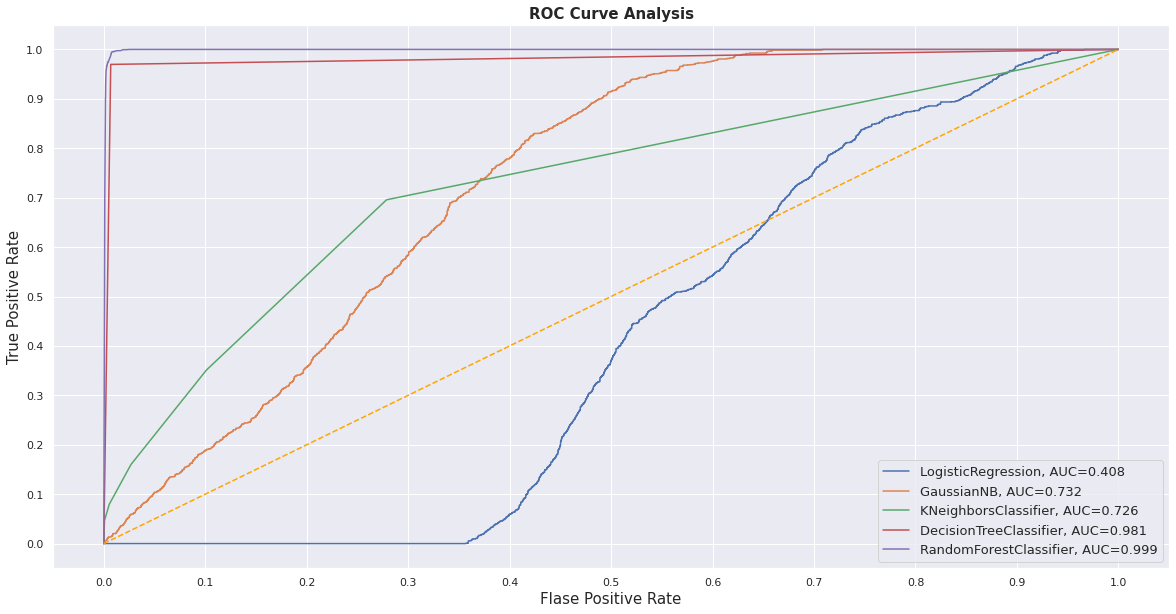

In [30]:
fig = plt.figure(figsize=(20,10))

for i in table.index:
    plt.plot(table.loc[i]['fpr'], 
             table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

As we can see Decision Tree and Random Forest Classifiers perform the best though they overfit. I will next explore Isolation Forrest on an Unsupervised set (no labels) and observe results.

## Isolation Forest Model on Unsupervised Data

Use the previously created DataFrame and keep only the data (drop the labels.)

In [31]:
df.head()
dfi = df[['date', 'vector', 'user', 'source', 'action']]
dfi.head()

,date,vector,user,source,action
0,1297937413000,1,443,613,2988
1,1274870737000,1,1087,1702,8444
2,1284991601000,1,686,1980,4707
3,1293611871000,1,680,1002,5315
4,1301299260000,1,1527,1444,11562


Initiate, fit, and predict the model (set contamination to 10%), create an outlier list that can be exported for further analysis, and count number of records in each class (anomaly vs non-anomaly.)

In [32]:
from sklearn.ensemble import IsolationForest

columns = dfi.columns[1:5]
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.10), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(dfi[columns])
pred = clf.predict(dfi[columns])
dfi['anomaly']=pred
outliers=dfi.loc[dfi['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(dfi['anomaly'].value_counts())

 1    58309
-1     6479
Name: anomaly, dtype: int64


In [33]:
dfi.head()

,date,vector,user,source,action,anomaly
0,1297937413000,1,443,613,2988,1
1,1274870737000,1,1087,1702,8444,1
2,1284991601000,1,686,1980,4707,1
3,1293611871000,1,680,1002,5315,1
4,1301299260000,1,1527,1444,11562,1


Normalize the data, reduce it to 3-dimensions, and plot it.

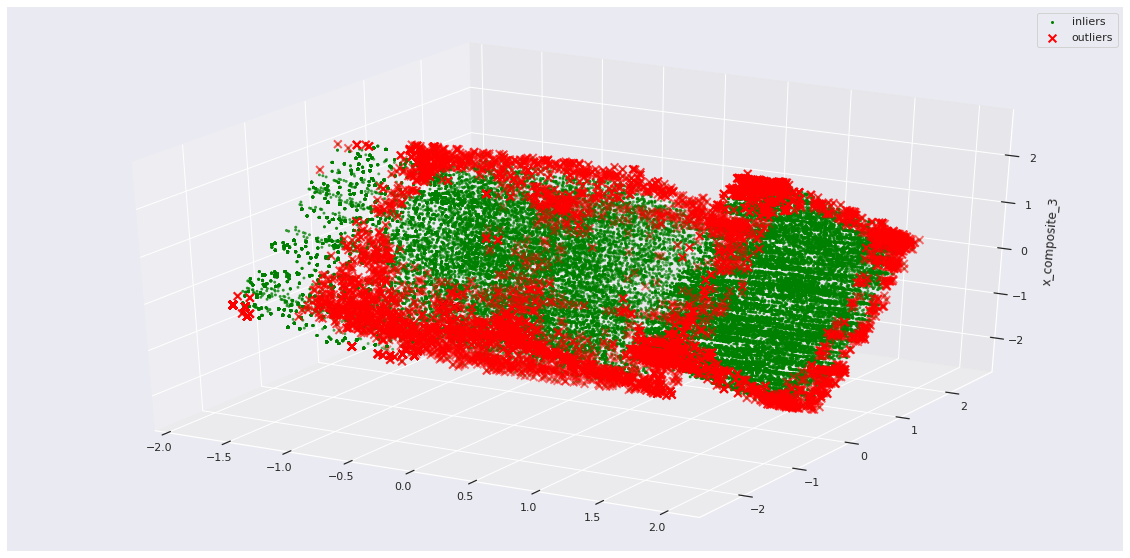

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rc('figure', figsize=(20, 10))
pca = PCA(n_components=3)
scaler = StandardScaler()

X = scaler.fit_transform(dfi[columns])
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")

ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

We can clearly see that the model is picking out the outliers though the data is synthetic and hence the figure is too geometric.

Final step is to save the "clean" encoded data to CSV for GitHub upload

In [37]:
df.to_csv('df_export_clean.csv')